In [132]:
import pandas as pd
import numpy as np

In [133]:
import tensorflow as tf 
from tensorflow.python.framework.ops import disable_eager_execution

# i have no idea why this is necessary but it is 
disable_eager_execution()

# Load in the data
cifar10 = tf.keras.datasets.cifar10
 
# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

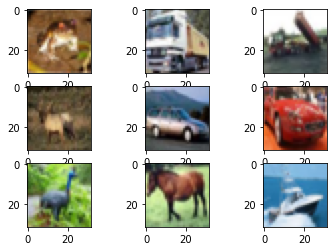

In [134]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# display a subset of images
def display_img(count, x_train):
    for i in range(count):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(x_train[i])
    # show the figure
    plt.show()

display_img(9, x_train)

In [135]:
#normalize data 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#pixel values between 0 and 1
x_train  /= 255
x_test /= 255
x_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [136]:
#flatten data for sklearn models 
x_train_flat = np.reshape(x_train, (x_train.shape[0], -1)) # [49000, 3072]
x_test_flat = np.reshape(x_test, (x_test.shape[0], -1)) # [10000, 3072]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
y_train_flat, y_test_flat = y_train.flatten(), y_test.flatten()

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [137]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_train_flat, y_train_flat)
preds = lr_model.predict(x_test_flat)
lr_model.score(x_test_flat, preds)

C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0

Original label is deer and predicted label is plane


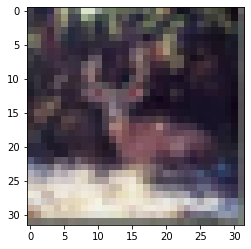

In [127]:
# sample prediction 

# select the image from our test dataset
image_number = 890
 
# display the image
plt.imshow(x_test_flat.reshape(x_test_flat.shape[0], 32, 32, 3)[image_number])
 
# load the image in an array
n = np.array(x_test_flat[image_number]).reshape(1, -1)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[lr_model.predict(n).argmax()]
 
# load the original label
original_label = classes[y_test_flat[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [10]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion="entropy")
dt_model.fit(x_train_flat, y_train_flat)
predict = dt_model.predict(x_test_flat)
dt_model.score(x_test_flat, y_test_flat)

0.2656

In [7]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
    

# number of classes
K = len(np.unique(y_train))
 
# calculate total number of classes
# for output layer
print("number of classes:", K)

# input layer
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

# Hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# last hidden layer i.e.. output layer
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# model description
model.summary()

number of classes: 10
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (No

In [8]:
# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Fit
r = model.fit(
  x_train, y_train, validation_data=(x_test, y_test), epochs=25)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
49984/50000 [============================>.] - ETA: 0s - loss: 1.3183 - accuracy: 0.5467WARNING:tensorflow:From C:\Users\mdsco\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
50000/50000 [==============================] - 111s 2ms/sample - loss: 1.3184 - accuracy: 0.5467 - val_loss: 0.9580 - val_accuracy: 0.6672
Epoch 2/25
50000/50000 [==============================] - 109s 2ms/sample - loss: 0.8397 - accuracy: 0.7085 - val_loss: 0.8884 - val_accuracy: 0.6983
Epoch 3/25
50000/50000 [==============================] - 110s 2ms/sample - loss: 0.6933 - accuracy: 0.7587 - val_loss: 0.8068 - val_accuracy: 0.7248
Epoch 4/25
50000/50000 [==============================

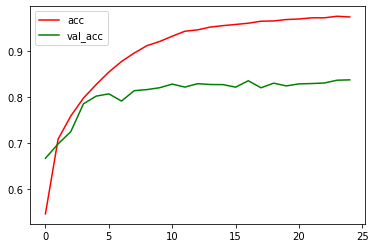

In [21]:
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [113]:
preds = model.predict(x_test)
preds

array([[3.4497652e-06, 2.0358991e-06, 1.1239081e-06, ..., 1.1615421e-05,
        1.9906514e-05, 1.5666005e-06],
       [4.5869242e-12, 5.1459313e-07, 3.9958588e-20, ..., 3.0433900e-22,
        9.9999952e-01, 1.0583951e-13],
       [1.4648913e-02, 1.6800899e-05, 4.2418598e-08, ..., 7.2652551e-11,
        9.8532158e-01, 1.2707323e-05],
       ...,
       [3.7257701e-22, 4.1153995e-26, 6.8848562e-13, ..., 3.9182270e-14,
        4.5445756e-24, 1.0457544e-23],
       [1.2915205e-02, 9.8266637e-01, 1.7091569e-03, ..., 5.9194492e-05,
        9.3213261e-05, 8.7861124e-05],
       [1.6058414e-23, 1.1167362e-27, 4.2634118e-22, ..., 1.0000000e+00,
        4.8120612e-29, 8.6513520e-21]], dtype=float32)

Original label is cat and predicted label is cat


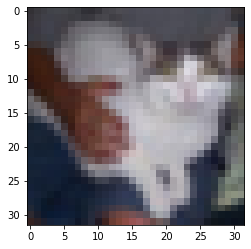

In [117]:
# select the image from our test dataset
image_number = 77
 
# display the image
plt.imshow(x_test[image_number])
 
# load the image in an array
n = np.array(x_test[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[model.predict(p).argmax()]
 
# load the original label
original_label = classes[y_test.flatten()[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [91]:
from art.estimators.classification import KerasClassifier
from art.estimators.classification import SklearnClassifier

# Create classifier wrappers for trained models
keras_classifier = KerasClassifier(model=model, clip_values=(0, 1))
logreg_classifier = SklearnClassifier(model=lr_model, clip_values=(0, 1))

In [92]:
# DeepFool attack for neural networks
from art.attacks.evasion import DeepFool

print("Create DeepFool attack")
adv_crafter = DeepFool(keras_classifier)
print("Craft attack test examples")
x_test_df = adv_crafter.generate(x_test)

Create DeepFool attack
Craft attack test examples


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

In [43]:
x_train_small_df = adv_crafter.generate(x_train[:5000])

DeepFool:   0%|          | 0/5000 [00:00<?, ?it/s]

In [44]:
x_train_adv_small = np.append(x_train[:5000], x_train_small_df, axis=0)
y_train_adv_small = np.append(y_train[:5000], y_train[:5000], axis=0)

In [58]:
# Evaluate the trained model on the adversarial samples
preds = np.argmax(model.predict(x_test_df), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Model before adversarial training")
print("Accuracy on adversarial samples: ", (acc * 100))

Model before adversarial training
Accuracy on adversarial samples:  20.169999999999998


Original label is cat and predicted label is dog


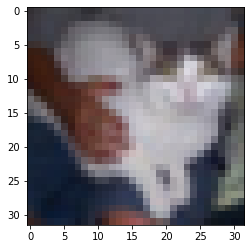

In [63]:
# select random image from DeepFool generated testing set 
image_number = 333
 
# display the image
plt.imshow(x_test_df[image_number])
 
# load the image in an array
n = np.array(x_test_df[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[model.predict(p).argmax()]
 
# load the original label
original_label = classes[y_test.flatten()[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [68]:
#Fast gradient method on neural network
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=keras_classifier, eps=0.1)
x_test_fgm = attack.generate(x=x_test)
preds = np.argmax(model.predict(x_test_fgm), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  10.530000000000001


In [69]:
from art.attacks.evasion import FastGradientMethod
#fast gradient method on logistic regression
attack = FastGradientMethod(estimator=logreg_classifier, eps=0.1)
x_test_fgm_flat = attack.generate(x=x_test_flat)
preds = lr_model.predict(x_test_fgm_flat)
acc = lr_model.score(x_test_fgm_flat, y_test_flat)
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  14.06


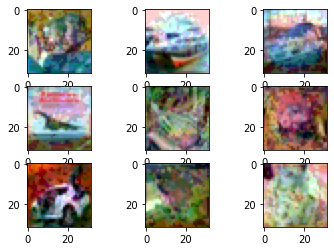

In [70]:
display_img(9, x_test_fgm_flat.reshape(x_test_fgm_flat.shape[0], 32, 32, 3))

Original label is frog and predicted label is bird


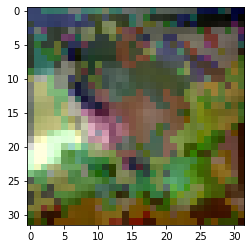

In [71]:
# select the image from our test dataset
image_number = 7
 
# display the image
plt.imshow(x_test_fgm_flat.reshape(x_test_fgm_flat.shape[0], 32, 32, 3)[image_number])
 
# load the image in an array
n = np.array(x_test_fgm_flat.reshape(x_test_fgm_flat.shape[0], 32, 32, 3)[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[model.predict(p).argmax()]
 
# load the original label
original_label = classes[y_test.flatten()[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [77]:
# try a defense. 
from art.defences.preprocessor import JpegCompression
defense = JpegCompression(clip_values=(0,1))
data = defense.__call__(x_test_df)

In [90]:
# try compressed testing data on trained model
preds = np.argmax(model.predict(data[0]), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Model before adversarial training")
print("Accuracy on adversarial samples: ", (acc * 100))

Model before adversarial training
Accuracy on adversarial samples:  8.55


In [87]:
x_test_df

array([[[[0.61955184, 0.4392156 , 0.19220011],
         [0.62345266, 0.43516135, 0.1842269 ],
         [0.6471897 , 0.45490408, 0.20010988],
         ...,
         [0.53734934, 0.37275213, 0.14119403],
         [0.49400723, 0.35701525, 0.14112318],
         [0.45485234, 0.33343554, 0.1293603 ]],

        [[0.5960726 , 0.43928632, 0.20013045],
         [0.59192294, 0.43104732, 0.1565341 ],
         [0.6232869 , 0.4464574 , 0.17597423],
         ...,
         [0.53273636, 0.37233448, 0.1207151 ],
         [0.4894428 , 0.35653532, 0.12457879],
         [0.46644977, 0.3450114 , 0.13279784]],

        [[0.5922943 , 0.43157208, 0.18455687],
         [0.59232235, 0.42733982, 0.12917842],
         [0.61951655, 0.4345762 , 0.14057952],
         ...,
         [0.5445781 , 0.38472694, 0.13301778],
         [0.5094316 , 0.37285706, 0.13282612],
         [0.47060037, 0.34920597, 0.1290368 ]],

        ...,

        [[0.26647294, 0.4862043 , 0.6941056 ],
         [0.1645085 , 0.3919369 , 0.58048236]

In [89]:
data[0]

array([[[[0.5882353 , 0.41960785, 0.10980392],
         [0.60784316, 0.4392157 , 0.12941177],
         [0.654902  , 0.47843137, 0.16078432],
         ...,
         [0.54509807, 0.37254903, 0.13333334],
         [0.5254902 , 0.3372549 , 0.08627451],
         [0.5019608 , 0.3137255 , 0.05490196]],

        [[0.60784316, 0.44313726, 0.14509805],
         [0.5921569 , 0.42745098, 0.12941177],
         [0.60784316, 0.4392157 , 0.13333334],
         ...,
         [0.5294118 , 0.3647059 , 0.12941177],
         [0.5176471 , 0.3372549 , 0.09411765],
         [0.5058824 , 0.32941177, 0.07450981]],

        [[0.61960787, 0.4627451 , 0.1882353 ],
         [0.5803922 , 0.42352942, 0.14901961],
         [0.5764706 , 0.4117647 , 0.12941177],
         ...,
         [0.5254902 , 0.37254903, 0.14901961],
         [0.52156866, 0.35686275, 0.12156863],
         [0.52156866, 0.34901962, 0.10196079]],

        ...,

        [[0.30980393, 0.5254902 , 0.7490196 ],
         [0.15294118, 0.35686275, 0.5803922 ]